# CIFAR10을 CNN으로 학습하기

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt

from torch.optim import lr_scheduler

batch_size=16
learning_rate=0.002
num_epoch=1

## 1. CIFAR10 train, test dataset 가져오기

In [2]:
cifar_train=dset.CIFAR10("CIFAR10/", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
cifar_test=dset.CIFAR10("CIFAR10/", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)


# data augmentation
# cifar_train=dset.CIFAR10("CIFAR10/", train=True,
#                          transform=transforms.Compose([
#                              transforms.Resize(36),
#                              transforms.CenterCrop(32),
#                              transforms.RandomHorizontalFlip(),
#                              transforms.Lambda(lambda x: x.rotate(90)),
#                              transforms.ToTensor()
#                          ]))

# data normalization
# cifar_train=dset.CIFAR10("CIFAR10/", train=True,
#                         transform=transforms.Compose([
#                             transforms.ToTensor(),
#                             transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
#                         ])
#                          , target_transform=None, download=False)

# cifar_test=dset.CIFAR10("CIFAR10/", train=False,
#                         transform=transforms.Compose([
#                             transforms.ToTensor(),
#                             transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
#                         ])
#                         , target_transform=None, download=False)


Files already downloaded and verified
Files already downloaded and verified


## 2. 대략적인 데이터 형태

cifar_train 길이:  50000
cifar_test 길이:  10000
image data 형태:  torch.Size([3, 32, 32])
label:  7


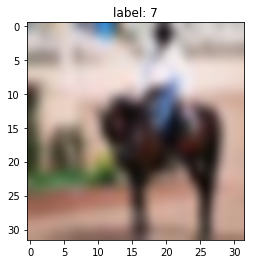

In [3]:
print ("cifar_train 길이: ", len(cifar_train))
print ("cifar_test 길이: ", len(cifar_test))

# 데이터 하나 형태
image, label=cifar_train.__getitem__(11)  # horse
print("image data 형태: ", image.size())
print("label: ", label)

# 그리기
# imshow()를 쓰려면 (channel, width, height)-> (width, height, channel) 바꿔야함
img=image.numpy()

r, g, b=img[0,:,:], img[1,:,:], img[2,:,:]
img2=np.zeros((img.shape[1], img.shape[2], img.shape[0]))
img2[:,:,0], img2[:,:,1], img2[:,:,2]=r, g, b

plt.title("label: %d" %label)
plt.imshow(img2, interpolation='bicubic')
plt.show()

In [3]:
# 성능을 측정하는 함수

def ComputeAcc(dloader, imodel):
    correct=0
    total=0
    
    for j, [imgs, labels] in enumerate(dloader):
        img=Variable(imgs, volatile=True)
        label=Variable(labels)
        
        output=imodel.forward(img)
        _, output_index=torch.max(output, 1)
        
        total+=label.size(0)
        correct+=(output_index==label).sum().float()
    print("Accuracy of Test Data: {}".format(100*correct/total))

## 3. 데이터 로드함수

In [4]:
train_loader=torch.utils.data.DataLoader(list(cifar_train)[:], batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader=torch.utils.data.DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)


## 4. 모델 선언 

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer=nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
#             nn.Dropout2d(0.2),
#             nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
#             nn.Dropout2d(0.2),
#             nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
#             nn.Dropout2d(0.2),
#             nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2)
        )
        self.fc_layer=nn.Sequential(
            nn.Linear(64*8*8, 100),
            nn.ReLU(),
#             nn.Dropout2d(0.2),
#             nn.BatchNorm1d(100),
            nn.Linear(100, 10)
        )
        
        # weight initialization
#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 init.kaiming_normal(m.weight.data)
#                 m.bias.data.fill_(0)
#             if isinstance(m, nn.Linear):
#                 init.kaiming_normal(m.weight.data)
#                 m.bias.data.fill_(0)
    
    def forward(self, x):
        out=self.layer(x)
        out=out.view(batch_size, -1)
        out=self.fc_layer(out)
        return out
        
model=CNN()

## 5. loss, optimizer

In [7]:
loss_func=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)
# optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)  # Adam optimizer
scheduler=lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.2)  # learning rate decay


## 6. 학습

In [8]:
for i in range(num_epoch):
    for j, [image, label] in enumerate(train_loader):
        x=Variable(image)
        y_=Variable(label)
        
        optimizer.zero_grad()
        output=model.forward(x)
        loss=loss_func(output, y_)
        loss.backward()
        optimizer.step()
        
        if j%1000==0:
            print(j, loss)

0 tensor(2.3271, grad_fn=<NllLossBackward>)
1000 tensor(2.2895, grad_fn=<NllLossBackward>)
2000 tensor(2.3062, grad_fn=<NllLossBackward>)
3000 tensor(2.2912, grad_fn=<NllLossBackward>)


In [17]:
# Naive Test
ComputeAcc(test_loader, model)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Accuracy of Test Data: 20.139999389648438


In [20]:
# dropout
ComputeAcc(test_loader, model)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Accuracy of Test Data: 10.40999984741211


In [29]:
# Data augmentation
ComputeAcc(test_loader, model)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Accuracy of Test Data: 15.210000038146973


In [35]:
# Weight Initialization
ComputeAcc(test_loader, model)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Accuracy of Test Data: 44.75


In [12]:
# Data Normalization
# 이거 하다가 에러남
# [Errno 12] Cannot allocate memory
ComputeAcc(test_loader, model)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Accuracy of Test Data: 26.770000457763672


In [12]:
# Batch Normalization
ComputeAcc(test_loader, model)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Accuracy of Test Data: 61.689998626708984


In [9]:
# Adam optimizer
ComputeAcc(test_loader, model)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Accuracy of Test Data: 58.5099983215332


In [9]:
# learning rate decay
ComputeAcc(test_loader, model)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Accuracy of Test Data: 12.609999656677246
